# Hamiltonian Diagonalization

The Hamiltonian itself is *not* a physical observable, but its eigenvalues (i.e., energy levels) are. To get the eigenvalues of a Hamiltonian for a periodic crystal, it is convenient to transform the Hamiltonian into reciprocal space (Brillouin zone) labeled by $k$, and the Hamiltonians on different $k$ points are decoupled from each other.

- A periodic Hamiltonian: $H_{ij,R_1,R_2}=H_{ij,0,R_2-R_1}\doteq H_{ij,R_2-R_1} \ \ \ \ \forall R_1,R_2$
- Fourier transform: $H_{ij(k)}=\sum_R e^{\mathbb{i}kR}H_{ij,R}$

A generalized eigenvalue problem $H_{(k)} |\psi_{k}\rangle = \varepsilon_{(k)} S_{(k)} |\psi_{k}\rangle$ can be solved on each $k$ point seperately. The eigenvalues $\varepsilon_{(k)}$ form the electronic band structure (band energies). 

DeepH-dock provides a set of diagonalization interfaces which take the DeepH-pack format data as input, construct the Hamiltonian matrix, and invoke `scipy.linalg.eigh` to diagonalize the Hamiltonian.

## Fermi energy

The fermi energy $\varepsilon_F$ is defined as the energy level where the number of states below is equal to the electronic occupation.

$$
\int_{-\infty}^{\varepsilon_F} D_{(\varepsilon)} d\varepsilon = N_{\text{ele}}
$$

where $D_{(\varepsilon)}$ is density of states and $N_{\text{ele}}$ is electronic occupation. The number of states below an energy level can be directly counted out or integrated out using the [tetrahedron method](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.49.16223).

To determine the fermi energy via the tool in DeepH-dock, the occupation number should be added to the `info.json` file. Note that the occupation always includes the spin degree of freedom, even when spinful is set to false.
```json
{
  "occupation": 46, 
  ...
}
```

The fermi energy can be determined by the command below.
```bash
dock compute eigen find-fermi -h
```
```
Usage: dock compute eigen find-fermi [OPTIONS] DATA_PATH

  Find the Fermi energy using the number of occupied electrons.

Options:
  -p, --parallel-num INTEGER      Number of processes for k-points.  [default: 1]
  --thread-num INTEGER            Number of threads for each k-point.  [default: 1]
  --method [counting|tetrahedron]
                                  Calculating method that is used for obtaining DOS.  [default: counting]
  -d, --kp-density FLOAT          The density of the k points.  [default: 0.1]
  --cache-res                     Cache the eigenvalues so that you can save time in the subsequent DOS calculation.
  -h, --help                      Show this message and exit.
```
The calculation directiory `DATA_PATH` should contain `POSCAR`, `info.json`, `overlap.h5`, and `hamiltonian.h5`. A 3D mesh of $k$ points is generated based on the three reciprocal lattice vectors, and the $k$ point spacing is determined by `kp-density` (measured in $\text{Ang}^{-1}$). The `parallel-num` controls the number of processes to treat $k$ points in parallel, and the `thread-num` controls the number of threads per process. The default method for the integration of $D_{(\varepsilon)}$ is counting the number of energy levels, which is convenient for insulators but inaccurate for metals. One can switch to the tetrahedron method by setting `--method tetrahedron` to perform more accurate calculation, which invokes the [libtetrabz](https://github.com/mitsuaki1987/libtetrabz) package. The eigenvalues will be dumped if `--cache_res` is specified and can be used to plot the density of states (see the next section). After the calculation, a file named `fermi_energy.json` is dumped. If needed, the fermi energy stored in the `fermi_energy.json` can replace the one in `info.json`.

Example:
```bash
dock compute eigen find-fermi ./eigen/MoTe2 -d 0.1 -p 16
```
```
Use dk=0.1 and k_mesh=[18 18  1]
Calculating eigenvalues with k_mesh=[18 18  1], k_process_num=16 ...
Determining fermi energy with method=counting ...
```
```json
{"fermi_energy_eV": 8.894647969025222}
```

**Note:**
- For small systems, a large number of $k$ points are needed and the most efficient way is setting `parallel-num` to be `CPU_NUM` (the number of available CPU cores) and setting `thread-num` to 1. For large systems, a small number of $k$ points (e.g., gamma-only) is sufficient to determine the fermi energy. The `parallel-num` can be set to the number of $k$ points and `thread-num` can be set to `CPU_NUM` divided by `parallel-num`.
- Although there is already a `fermi_energy_eV` attribute in `info.json`, the calculated fermi energy will not directly override it. If you are sure to use the new fermi energy in `fermi_energy.json`, you need to manually modify the `info.json` file. This prevents any unexpected irreversible changes to the `info.json` file.

## Density of states

The energy eigenvalues output by `find-fermi` can be used to calculate the density of states ($D_{(\varepsilon)}$). The eigenvalues on a $k$ mesh are discrete sampling points on the continuous energy bands, and should be expanded to give an approximation to the continuous $D_{(\varepsilon)}$. The commonly used methods are smearing and tetrahedron method.

The density of states can be calculated by the following command:
```bash
dock compute eigen calc-dos -h
```
```
Usage: dock compute eigen calc-dos [OPTIONS] DATA_PATH

  Calc and plot the density of states.

Options:
  -p, --parallel-num INTEGER      Number of processes for k-points.  [default: 1]
  --thread-num INTEGER            Number of threads for each k-point.  [default: 1]
  --method [gaussian|tetrahedron]
                                  Calculating method that is used for obtaining DOS.  [default: gaussian]
  -d, --kp-density FLOAT          The density of the k points.  [default: 0.1]
  --energy-window, --E-win <FLOAT FLOAT>...
                                  Plot band energy window (respect to fermi energy).  [default: -5, 5]
  -s, --smearing FLOAT            The smearing width (eV) in gaussian method.  [default: -1.0]
  --energy-num, --num INTEGER     Number of energy points.  [default: 201]
  --cache-res                     Cache the eigenvalues so that you can save time in the next same task.
  -h, --help                      Show this message and exit.
```
The options `parallel-num`, `thread-num`, and `kp-density` have the same meaning as in `find-fermi`. The cached result of eigenvalues will be used if its $k$ mesh matches with current `kp-density`, otherwise the eigenvalues will be recalculated. The default expansion method is gaussian smearing, with `-s` option specifying the smearing width. The smearing width needs to be adjusted to balance between smoothness and fidelity of the plot. One can switch to the tetrahedron method by setting `--method tetrahedron` to perform more accurate calculation, and no parameters need to be adjusted.

Example:
```bash
dock compute eigen calc-dos ./eigen/MoTe2 -d 0.03 --energy-window -2.0 2.0 --energy-num 1000 -s 0.04 -p 16
```
```
Use cached fermi energy from fermi_energy.json
Use dk=0.03 and k_mesh=[58 58  1]
Calculating eigenvalues with k_mesh=[58 58  1], k_process_num=16 ...
Calculating DOS with emin=-2.0 eV, emax=2.0 eV, enum=1000, method=gaussian ...
  Using sigma=0.04 eV for gaussian smearing
Ploting DOS ...
```
![MoTe2_dos.png](./figures.bak/dos.png)

## Band structure

The band structure is one of the most basic and important electronic information in materials study. DeepH-dock provides terminal tool to calculate the band structure. The diagonalization is performed by the same module as previous sections, and the difference is that the $k$ points are set along several paths in the reciprocal space.

The $k$ paths need to be specified by the `K_PATH` file which looks like:
```bash
20  0.000000 0.000000 0.000000  0.000000 0.500000 0.000000  Gamma M
20  0.000000 0.500000 0.000000  0.333333 0.333333 0.000000  M K
20  0.333333 0.333333 0.000000  0.000000 0.000000 0.000000  K Gamma 
```
In the `K_PATH` file, each row denotes a $k$ path, with the first column specifying the number of $k$ points in the path, and followed by the coordinates of the starting and ending $k$ points in the reciprocal space. The last two columns specify the label of the starting and ending $k$ points.

The band structure can be calculated by the following command. The calculation directiory `DATA_PATH` should contain `POSCAR`, `info.json`, `overlap.h5`, `hamiltonian.h5`, and `K_PATH`. 
```bash
dock compute eigen calc-band -h
```
```
Usage: dock compute eigen calc-band [OPTIONS] DATA_PATH

  Calculate the energy band and save it into h5 file.

Options:
  -p, --parallel-num INTEGER  The parallel processing number, -1 for using all of the cores.  [default: -1]
  --thread-num INTEGER        Number of threads for each k-point.  [default: 1]
  --sparse-calc               Use sparse diagonalization.
  --num-band INTEGER          Number of bands when using sparse diagonalization.  [default: 50]
  --E-min, --min FLOAT        Lowest band energy (from the fermi level) when using sparse diagonalization.  [default: -0.5]
  --maxiter INTEGER           Max number of iterations when using sparse diagonalization.  [default: 300]
  -h, --help                  Show this message and exit.
```
The options `parallel-num` and `thread-num` have the same meaning as in `find-fermi`. Sparse diagonalization is switched on by the `--sparse_calc` tag, and the options `num-band`, `E-min` and `maxiter` specify the behavior of the sparse solver.

Both the raw data `band.h5` and the figure `band.png` is generated. The `band.png` is for a first glance and can be replotted by the following command:
```bash
dock compute eigen plot-band -h
```
```
Usage: dock compute eigen plot-band [OPTIONS] DATA_PATH

  Plot energy band with the h5 file that is calculated already.

Options:
  --energy-window, --E-win <FLOAT FLOAT>...
                                  Plot band energy window (respect to fermi energy).  [default: -5, 5]
  -h, --help                      Show this message and exit.
```

Example:
```bash
dock compute eigen calc-band ./eigen/MoTe2 -p 16
dock compute eigen plot-band ./eigen/MoTe2 --energy-window -2.0 2.0
```
![MoTe2_band.png](./figures.bak/band.png)

## Class API

DeepH-dock provides the `HamiltonianObj` class to deal with tight-binding Hamiltonian objects. Advanced users can construct the HamiltonianObj from the DeepH-pack format data and perform the operations (e.g., diagonalization, calculation of response properties and transition probabilities, etc.) by themselves.

In [1]:
from deepx_dock.compute.eigen.hamiltonian import HamiltonianObj
print(HamiltonianObj.__doc__)


Tight-binding Hamiltonian in the matrix form.

This class constructs the Hamiltonian operator from the standard DeepH 
format data. The Hamiltonian and overlap matrix in real space (H(R) and S(R))
are constructed and can be Fourier transformed to the reciprocal space 
(H(k) and S(k)). The diagonalization of the Hamiltonian is also supported.

Parameters
----------
info_dir_path : str 
    Path to the directory containing the POSCAR, info.json and overlap.h5.

H_file_path : str (optional)
    Path to the Hamiltonian file. Default: hamiltonian.h5 under `info_dir_path`.

Properties:
----------
lattice : np.array((3, 3), dtype=float)
    Lattice vectors. Each row is a lattice vector.

reciprocal_lattice : np.array((3, 3), dtype=float)
    Reciprocal lattice vectors. Each row is a reciprocal lattice vector.

Rijk_list : np.array((N_R, 3), dtype=int)
    Lattice displacements for inter-cell hoppings.
    The displacements are expressed in terms of the lattice vectors.
    N_R is the number 

In [2]:
from deepx_dock.compute.eigen.hamiltonian import HamiltonianObj
print(HamiltonianObj.diag.__doc__)


Diagonalize the Hamiltonian at specified k-points to obtain eigenvalues (bands) 
and optionally eigenvectors (wave functions).

This function supports both dense (scipy.linalg.eigh) and sparse (scipy.sparse.linalg.eigsh) 
solvers and utilizes parallel computing via joblib.

Parameters
----------
ks : array_like, shape (Nk, 3)
    List of k-points in reduced coordinates (fractional).
k_process_num : int, optional
    Number of parallel processes to use (default is 1).
    If > 1, BLAS threads per process are restricted to 1 to avoid oversubscription.
sparse_calc : bool, optional
    If True, use sparse solver (eigsh). If False, use dense solver (eigh).
    Default is False.
bands_only : bool, optional
    If True, only compute and return eigenvalues. Faster and uses less memory.
    Default is False.
**kwargs : dict
    Additional keyword arguments passed to the solver.
    - For sparse_calc=True (eigsh): 'k' (num eigenvalues), 'which' (e.g., 'SA'), 'sigma', etc.
    - For sparse_calc=

The example below shows how to construct the Hamiltonian operator and calculate the band structure.

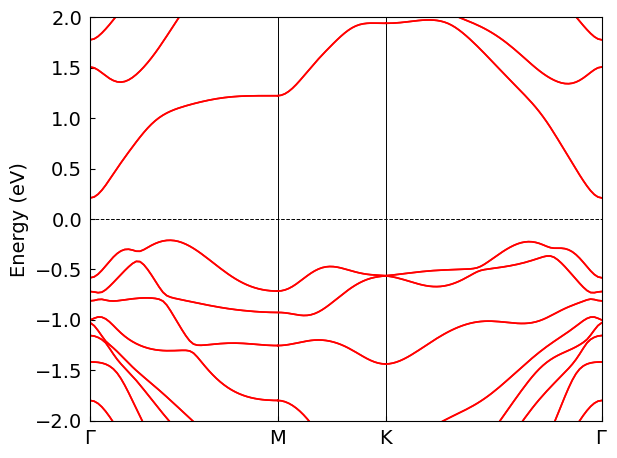

In [3]:
from deepx_dock.compute.eigen.hamiltonian import HamiltonianObj
from deepx_dock.compute.eigen.band import BandDataGenerator, BandPlotter

data_path = "./eigen/Bi2Se3_SOC"
band_conf = {
    "k_list_spell" : """
        50   0.0000000000   0.0000000000   0.0000000000   0.5000000000   0.0000000000   0.0000000000     GAMMA               M              
        30   0.5000000000   0.0000000000   0.0000000000   0.3333333333   0.3333333333   0.0000000000     M                   K              
        60   0.3333333333   0.3333333333   0.0000000000   0.0000000000   0.0000000000   0.0000000000     K                   GAMMA          
    """
}
band_data_path = "./eigen/Bi2Se3_SOC/band_data.h5"
window = [-2, 2]

obj_H = HamiltonianObj(data_path)
bd_gen = BandDataGenerator(obj_H, band_conf)
bd_gen.calc_band_data()
bd_gen.dump_band_data(band_data_path)
bd_plotter = BandPlotter(band_data_path)
bd_plotter.plot(*window)